In [1]:
from estnltk import Text

from pandas import read_csv
from estnltk.taggers import RegexTagger

from estnltk.spans import Span, SpanList
from estnltk.layer import Layer
from estnltk.finite_grammar.layer_graph import print_nodes
import csv
from estnltk.finite_grammar import PhraseListTagger

from estnltk.taggers import GapTagger
from estnltk.taggers import EnvelopingGapTagger
from estnltk.taggers import MergeTagger

from estnltk.layer_operations.flatten import flatten

from estnltk.finite_grammar.layer_graph import layer_to_graph, plot_graph
from estnltk.finite_grammar.grammar import parse_graph

import re

In [2]:
specification = [
    ('parem',),
    ('vasak',), 
    ('eesmine',),
    ('tagumine',),
    ('külgmine',)
    ]

In [3]:
bodypart = [
    ('neer',),
    ('põlv',), 
    ('kops',),
    ('aju',),
    ('külgvatsake',)
    ]

In [4]:
def specification_decorator(text, span, phrase):
    return {'match': phrase, 'grammar_symbol': 'SPECIFICATION', 
            'form': str(span.form), 'partofspeech': str(span.partofspeech)}

In [5]:
specification_tagger = PhraseListTagger(layer_name='specification',
                              input_layer = 'morph_analysis',
                               input_attribute='lemma',
                             phrase_list=specification,
                               decorator = specification_decorator,
                             attributes=('match', 'grammar_symbol', 'form', 'partofspeech'),
                             conflict_resolving_strategy= 'MAX'
                              )

In [6]:
def bodypart_decorator(text, span, phrase):
    return {'match': phrase, 'grammar_symbol': 'BODYPART', 
            'form': str(span.form), 'partofspeech': str(span.partofspeech)}

In [7]:
bodypart_tagger = PhraseListTagger(layer_name='bodypart',
                              input_layer = 'morph_analysis',
                               input_attribute='lemma',
                             phrase_list=bodypart,
                               decorator = bodypart_decorator,
                             attributes=('match', 'grammar_symbol', 'form', 'partofspeech'),
                             conflict_resolving_strategy= 'MAX'
                              )

In [8]:
taggers = {}
taggers['bodypart_tagger'] = bodypart_tagger
#taggers['location_tagger'] = location_tagger
taggers['specification_tagger'] = specification_tagger

In [9]:
def gaps_decorator(text:str):
    return {'gap_length':len(text), 'grammar_symbol': 'RANDOM_TEXT'}

In [10]:
def trim(text):
    t_1 = re.sub('\s*', '', text)
    t_1 = re.sub('\s+(on|oli)\s+', '', t_1)
    
    return t_1

In [11]:
gap_tagger = EnvelopingGapTagger(layer_name='gaps',
                                 input_layers=['bodypart', 
                                               #'location_tagger',
                                               'specification'
                                              ],
                                 enveloped_layer='morph_analysis',
                                 decorator=gaps_decorator,
                                 attributes=['grammar_symbol'])

In [12]:
merge_tagger = MergeTagger(layer_name='grammar_tags',
                           input_layers=['bodypart',
                                       #'location_tagger',
                                         'specification',
                                      'gaps'],
                           attributes=('grammar_symbol', 'value', 'form', 'partofspeech'))

In [13]:
def tag_sent(sent):
    sent = Text(sent)
    sent.analyse('morphology')
    for tagger in taggers:
        taggers[tagger].tag(sent)
        #temp_layer = taggers[tagger].tag(sent, return_layer = True)
        #sent[tagger] = flatten(temp_layer, tagger)
        #sent[tagger] = temp_layer
    gap_tagger.tag(sent)
    merge_tagger.tag(sent)
    return sent

In [14]:
i = 'vasakus põlves valu'

In [15]:
j = tag_sent(i)

In [16]:
j

Text(text="vasakus põlves valu")

In [17]:
j.grammar_tags

SL[SL[SL[Span(vasakus, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'vasak', 'partofspeech': 'A', 'root': 'vasak', 'root_tokens': ('vasak',)})]],
SL[SL[Span(põlves, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'põli', 'partofspeech': 'S', 'root': 'põli', 'root_tokens': ('põli',)}),
Span(põlves, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'põlv', 'partofspeech': 'S', 'root': 'põlv', 'root_tokens': ('põlv',)})]],
SL[SL[Span(valu, {'clitic': '', 'ending': '0', 'form': 'sg p', 'lemma': 'valu', 'partofspeech': 'S', 'root': 'valu', 'root_tokens': ('valu',)})]]]

In [18]:
graph = layer_to_graph(j['grammar_tags'])

In [19]:
graph

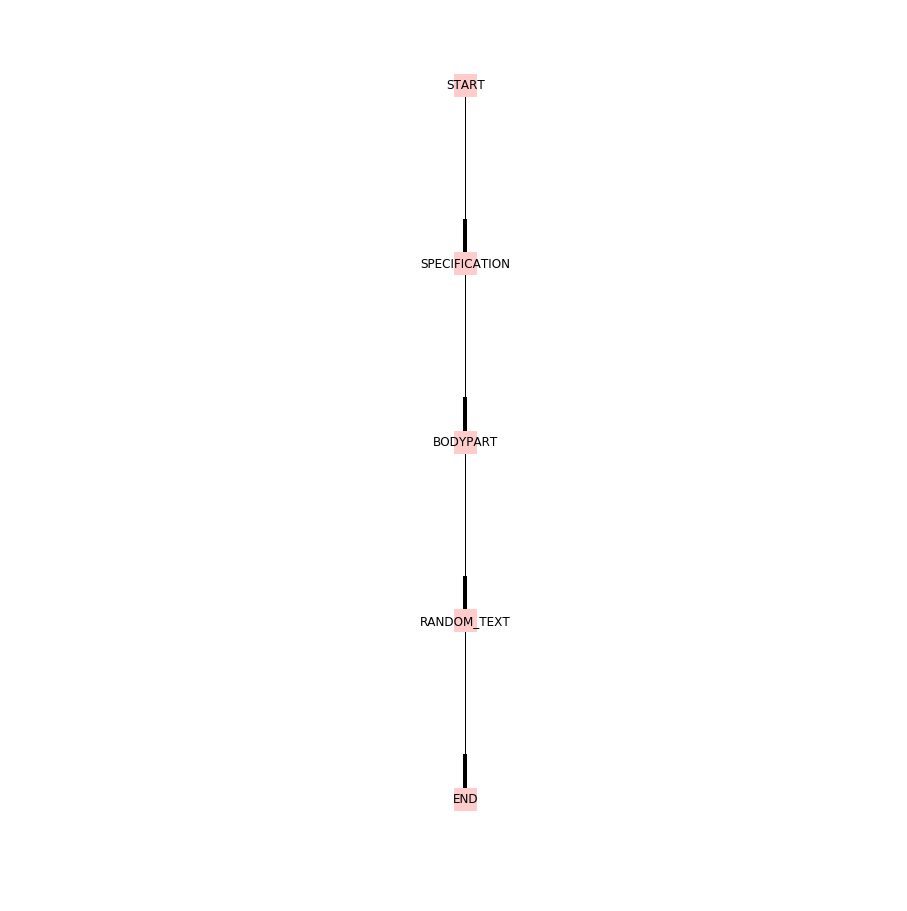

In [20]:
plot_graph(graph)

In [21]:
from estnltk.finite_grammar.grammar import Rule, Grammar

rules = []



rules.append(Rule('COMPLEMENT', 'SPECIFICATION'))


rules.append(Rule('MAIN', 'BODYPART', group = 'g1', priority = 1))



rules.append(Rule('COMP_MAIN', 'COMPLEMENT MAIN'))#, decorator = complement_decorator))


grammar = Grammar(start_symbols=['COMP_MAIN'
                                
                                ], rules=rules, max_depth = 4, 
                 legal_attributes=['form', 'type'])
grammar



Grammar:
	start: COMP_MAIN
	terminals: BODYPART, SPECIFICATION
	nonterminals: COMPLEMENT, COMP_MAIN, MAIN
	legal attributes: frozenset({'form', 'type'})
	max_depth: 4
Rules:
	COMPLEMENT -> SPECIFICATION	: 0, val: default_validator, dec: default_decorator
	MAIN -> BODYPART	: 1, val: default_validator, dec: default_decorator
	COMP_MAIN -> COMPLEMENT MAIN	: 0, val: default_validator, dec: default_decorator

In [22]:
graph = layer_to_graph(j['grammar_tags'])

In [23]:
parse_graph(graph, grammar, 4)

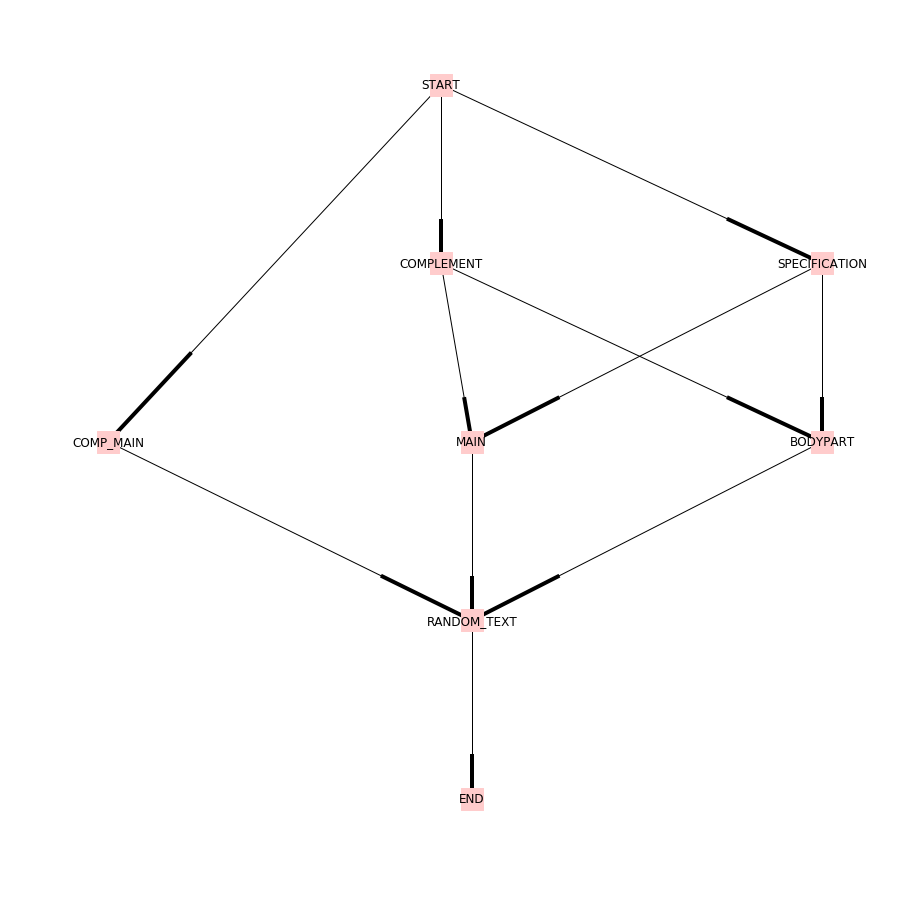

In [24]:
plot_graph(graph)

In [25]:
print_nodes(graph, j, 
        names={'COMP_MAIN', 'RANDOM_TEXT', 'COMPLEMENT', 'RANDOM_TEXT'},
        attributes=['name', 'text', 'form', 'partofspeech', 'type'])

name                text                form                partofspeech        type                

COMPLEMENT          vasakus                                                                         
COMP_MAIN           vasakus põlves                                                                  
RANDOM_TEXT         valu                None                None                                    


In [26]:
from estnltk.taggers.grammar_parsing.grammar_parsing_tagger import GrammarParsingTagger
parsing_tagger = GrammarParsingTagger(layer_name='parse',
                                      attributes=['form', 'type'],
                                      layer_of_tokens='grammar_tags',
                                      grammar=grammar,
                                      output_nodes={'COMP_MAIN', 'COMPLEMENT', 'MAIN','RANDOM_TEXT'})

In [27]:
parsing_tagger.tag(j)
j.parse

SL[SL[SL[Span(vasakus, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'vasak', 'partofspeech': 'A', 'root': 'vasak', 'root_tokens': ('vasak',)})]],
SL[SL[Span(vasakus, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'vasak', 'partofspeech': 'A', 'root': 'vasak', 'root_tokens': ('vasak',)})],
SL[Span(põlves, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'põli', 'partofspeech': 'S', 'root': 'põli', 'root_tokens': ('põli',)}),
Span(põlves, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'põlv', 'partofspeech': 'S', 'root': 'põlv', 'root_tokens': ('põlv',)})]],
SL[SL[Span(põlves, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'põli', 'partofspeech': 'S', 'root': 'põli', 'root_tokens': ('põli',)}),
Span(põlves, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'põlv', 'partofspeech': 'S', 'root': 'põlv', 'root_tokens': ('põlv',)})]],
SL[SL[Span(valu, {'clitic': '', 'ending': '0', 'form': 'sg p', 'lemma': 'valu', 'partofspeech': 'S', 'root': 'valu', 'root_tokens': ('valu',)})]]]